In [1]:
import scipy as sp
import numpy as np
import os 
os.environ["CUDA_VISIBLE_DEVICES"] = "1"

import pickle

import tensorflow as tf
import matplotlib.pyplot as plt
from datetime import datetime

from architectures.bicycle_GAN import *

In [2]:
task='TRAIN'
#task='TEST'

# Option to save and restore hyperparameters

PATH='test11'

In [3]:
if task =='TRAIN' and os.path.exists(PATH+'/hyper_parameters.pkl'):
    with open(PATH+'/hyper_parameters.pkl', 'rb') as f:  
        hyper_dict = pickle.load(f)
        for key, item in hyper_dict.items():
            print(key+':'+str(item))
     
    reco_path = hyper_dict['reco_path']
    true_path = hyper_dict['true_path']
    n_batches = hyper_dict['n_batches']
    test_size = hyper_dict['test_size']
    LEARNING_RATE = hyper_dict['LEARNING_RATE']
    BETA1 = hyper_dict['BETA1']
    BATCH_SIZE = hyper_dict['BATCH_SIZE']
    EPOCHS = hyper_dict['EPOCHS']
    SAVE_SAMPLE_PERIOD = hyper_dict['SAVE_SAMPLE_PERIOD']
    SEED = hyper_dict['SEED']
    d_sizes = hyper_dict['d_sizes']
    g_sizes_enc = hyper_dict['g_sizes_enc']
    g_sizes_dec = hyper_dict['g_sizes_dec']
    e_sizes = hyper_dict['e_sizes']
    cost_type = hyper_dict['cost_type']
    validating_size=hyper_dict['validating_size']
    cycl_weight=hyper_dict['cycl_weight']
    latent_weight=hyper_dict['latent_weight']
    kl_weight=hyper_dict['kl_weight']
    discr_steps=hyper_dict['discr_steps']
    gen_steps=hyper_dict['gen_steps']
    vae_steps=hyper_dict['vae_steps']
    
elif task=='TRAIN' and not os.path.exists(PATH+'/hyper_parameters.pkl'):
    
    reco_path = '/disk/lhcb_data/davide/HCAL_project_full_event/reco/'
    true_path = '/disk/lhcb_data/davide/HCAL_project_full_event/true/'
    #reco_path = '/disk/lhcb_data/davide/HCAL_project_single_pion/piplus_cells_inout/piplus/reco/'
    #true_path = '/disk/lhcb_data/davide/HCAL_project_single_pion/piplus_cells_inout/piplus/true/'
    n_batches = 2
    test_size = 1000
    validating_size=1000
    
    LEARNING_RATE = 4e-5
    BETA1 = 0.5
    BATCH_SIZE = 32
    EPOCHS = 4
    SAVE_SAMPLE_PERIOD = 400
    SEED = 1
    cost_type='FEATURE'
    
    latent_weight=1
    cycl_weight=1
    kl_weight=1
    discr_steps=1
    gen_steps=1
    vae_steps=1

    latent_dims=128
    ndf = 16
    ngf = 16
    nef = 16
    s = 2
    f = 4
    d = 0.7
    
    stddev_d=0.02
    stddev_g=0.02
    stddev_e=0.02


    g_sizes_enc={
        'latent_dims':latent_dims,
    
        'conv_layers': [
                            (ngf/2, f,   s,  False, 1, lrelu, tf.truncated_normal_initializer(stddev_g)), #(batch, 52, 64, 1) =>  (batch, 26, 32, ngf)
                            (ngf,   f,   s, 'bn',  d,  lrelu, tf.truncated_normal_initializer(stddev_g)),#(batch, 26, 32, ngf) => (batch, 13, 16, ngf*2)
                            (ngf*2, f,   s, 'bn',  1,  lrelu, tf.truncated_normal_initializer(stddev_g)),#(batch, 13, 16, ngf*4) => (batch, 7, 8, ngf*4)
                            (ngf*4, f,   s, 'bn',  1,  lrelu, tf.truncated_normal_initializer(stddev_g)),#(batch, 7, 8, ngf*4) => (batch, 4, 4, ngf*4)
                            (ngf*8, f,   s, 'bn',  d,  lrelu, tf.truncated_normal_initializer(stddev_g)),#(batch, 4, 4, ngf*4) => (batch, 2, 2, ngf*4)
                        
                       ],
    }
    
    g_sizes_dec={
    
         
         'deconv_layers': [
    
                            (ngf*4, f,   s,  'bn',   1, lrelu, tf.truncated_normal_initializer(stddev_g)),#(batch, 1, 1, ngf*4) => (batch, 2, 2, ngf*4*2)
                            (ngf*2, f,   s,  'bn',   d, lrelu, tf.truncated_normal_initializer(stddev_g)),#(batch, 2, 2, ngf*4*2) => (batch, 4, 4, ngf*4*2)
                            (ngf,   f,   s,  'bn',   1, lrelu, tf.truncated_normal_initializer(stddev_g)),#(batch, 4, 4, ngf*4*2) => (batch, 7, 8, ngf*4*2)
                            (ngf/2, f,   s,  'bn',   1, lrelu, tf.truncated_normal_initializer(stddev_g)),#(batch, 7, 8, ngf*4*2) => (batch, 13, 16, ngf*2*2)
                            (1,     f,   s,   False, d, tf.identity, tf.truncated_normal_initializer(stddev_g)),#(batch, 26, 32, ngf*2) => (batch, 52, 64, 1)
                       
                         ],  
    }
    
    
    d_sizes={
        
         'conv_layers': [
                             (ndf/2,  f, s,  False, 1, lrelu, tf.truncated_normal_initializer(stddev_d)), #(batch, 52, 64, 2) => (batch, 26, 32, ndf)
                             (ndf,    f, s, 'bn',   d, lrelu, tf.truncated_normal_initializer(stddev_d)), #(batch, 26, 32, ndf) => (batch, 13, 16, ndf*2)
                             (ndf*2,  f, s, 'bn',   1, lrelu, tf.truncated_normal_initializer(stddev_d)), #(batch, 13, 16, ndf*2) => (batch, 7, 8, ndf*4)
                             (ndf*4,  f, s, 'bn',   d, lrelu, tf.truncated_normal_initializer(stddev_d)), #(batch, 7, 8, ndf*4) => (batch, 7, 8, ndf*8)
                             (ndf*8,  f, 1, 'bn',   1, lrelu, tf.truncated_normal_initializer(stddev_d)), #(batch, 7, 8, ndf*8) => (batch, 7, 8, ndf*8)
                             
                        ],
                        
         
         'dense_layers': [
                             (ndf*32, 'bn',  d, lrelu, tf.truncated_normal_initializer(stddev_d)),
                             (ndf*4,  'bn',  d, lrelu, tf.truncated_normal_initializer(stddev_d)),             
                             (ndf,   False,  d, lrelu, tf.truncated_normal_initializer(stddev_d))],
        
         'readout_layer_w_init':tf.truncated_normal_initializer(stddev_d),
    }
    

    
    e_sizes={
        'latent_dims':latent_dims,
        
        'conv_layers':[
            
                            (nef/2, f,   s,   False, 1, lrelu, tf.random_normal_initializer(stddev_e)),
                            (nef,   f,   s,   'bn',  1, lrelu, tf.random_normal_initializer(stddev_e)),
                            (nef*2, f,   s,   'bn',  d, lrelu, tf.random_normal_initializer(stddev_e)),
                            (nef*4, f,   s,   'bn',  1, lrelu, tf.random_normal_initializer(stddev_e)),
                            (nef*8, f,   s,   'bn',  d, lrelu, tf.random_normal_initializer(stddev_e)),
                        ],

        
        'dense_layers':[    
                            (nef*16, 'bn',   d, lrelu, tf.random_normal_initializer(stddev_e)),
                            (nef*8,  'bn',   d, lrelu, tf.random_normal_initializer(stddev_e)),
                            (nef,     False, d, lrelu, tf.random_normal_initializer(stddev_e)),
                      
                        ],
        'readout_layer_w_init':tf.random_normal_initializer(stddev_e)
        
    }

In [4]:
if task == 'TEST' and os.path.exists(PATH+'/hyper_parameters.pkl'):
    with open(PATH+'/hyper_parameters.pkl', 'rb') as f:  
        hyper_dict = pickle.load(f)
        for key, item in hyper_dict.items():
            print(key+':'+str(item))
     
    reco_path = hyper_dict['reco_path']
    true_path = hyper_dict['true_path']
    #true_path_K = hyper_dict['true_path_K']
    n_batches = hyper_dict['n_batches']
    test_size = hyper_dict['test_size']
    LEARNING_RATE = hyper_dict['LEARNING_RATE']
    BETA1 = hyper_dict['BETA1']
    BATCH_SIZE = hyper_dict['BATCH_SIZE']
    EPOCHS = hyper_dict['EPOCHS']
    SAVE_SAMPLE_PERIOD = hyper_dict['SAVE_SAMPLE_PERIOD']
    SEED = hyper_dict['SEED']
    d_sizes = hyper_dict['d_sizes']
    g_sizes_enc = hyper_dict['g_sizes_enc']
    g_sizes_dec = hyper_dict['g_sizes_dec']
    e_sizes = hyper_dict['e_sizes']
    cost_type = hyper_dict['cost_type']
    validating_size=hyper_dict['validating_size']
    cycl_weight=hyper_dict['cycl_weight']
    latent_weight=hyper_dict['latent_weight']
    kl_weight=hyper_dict['kl_weight']
    discr_steps=hyper_dict['discr_steps']
    gen_steps=hyper_dict['gen_steps']
    vae_steps=hyper_dict['vae_steps']

In [5]:
start_batch=0
train_true, test_true, train_TIS_true, test_TIS_true, train_TOS_true, test_TOS_true, train_reco, test_reco = load_data(true_path, reco_path, n_batches, start_batch,  test_size=test_size)
    
train_true, train_reco = delete_undetected_events_double(train_true, train_reco)
test_true, test_reco = delete_undetected_events_double(test_true, test_reco)

In [6]:
#train_true=train_true/1000.
#train_reco=train_reco/1000.
#
#test_true=test_true/1000.
#test_reco=test_reco/1000.

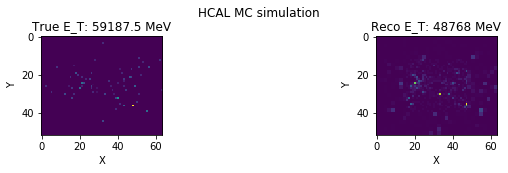

In [7]:
draw_one_sample(train_true,train_reco)

In [8]:
def HCAL():

    
    tf.reset_default_graph()
    tf.add_check_numerics_ops()
    
    _, n_H_A, n_W_A ,n_C = train_true.shape
    _, n_H_B, n_W_B ,n_C = train_reco.shape
    gan = bicycle_GAN(n_H_A, n_W_A, n_H_B, n_W_B, n_C,
                   min_true=min_true, max_true=max_true, 
                   min_reco=min_reco, max_reco=max_reco,
                   d_sizes=d_sizes, g_sizes_enc=g_sizes_enc, g_sizes_dec=g_sizes_dec, e_sizes=e_sizes,
                   lr=LEARNING_RATE, beta1=BETA1,
                   cost_type=cost_type, cycl_weight=cycl_weight, latent_weight=latent_weight, kl_weight=kl_weight,
                   discr_steps=discr_steps, gen_steps=gen_steps, vae_steps=vae_steps,
                   batch_size=BATCH_SIZE, epochs=EPOCHS,
                   save_sample=SAVE_SAMPLE_PERIOD, path=PATH, seed= SEED)
    
    vars_to_train= tf.trainable_variables()
    
    if task == 'TRAIN':
    
        init_op = tf.global_variables_initializer()
    
    
    if task == 'TEST':
    
        vars_all = tf.global_variables()
        vars_to_init = list(set(vars_all)-set(vars_to_train))
        init_op = tf.variables_initializer(vars_to_init)
            
    saver=tf.train.Saver()
    # Add ops to save and restore all the variables.
    
    gpu_options = tf.GPUOptions(per_process_gpu_memory_fraction=0.15)
    
    with tf.Session(config=tf.ConfigProto(gpu_options=gpu_options )) as sess:
        
        sess.run(init_op)
        
        if task=='TRAIN':
            
            if os.path.exists(PATH+'/'+PATH+'bicycle.ckpt.index'):
                saver.restore(sess,PATH+'/'+PATH+'bicycle.ckpt')
                print('Model restored.')
                
            gan.set_session(sess)
            gan.fit(train_true,train_reco, validating_size)
            
            save_all = saver.save(sess, PATH+'/'+PATH+'bicycle.ckpt')
            print("Model saved in path: %s" % save_all)
                  
                       
        if task=='TEST':
            
            print('\n Evaluate model on test set...')
            
            if os.path.exists(PATH+'/'+PATH+'bicycle.ckpt.index'):
                saver.restore(sess, PATH+'/'+PATH+'bicycle.ckpt')
                
            print('Model restored.')
            
            gan.set_session(sess)
        
        #test_reco_NN=gan.get_samples_A_to_B(test_true.reshape(test_true.shape[0],n_H_A,n_W_A,n_C))
        test_reco_NN=np.zeros_like(test_true)
        t0 = datetime.now()
        for i in range(len(test_true)):
            test_reco_NN[i]=gan.get_sample_A_to_B(test_true[i].reshape(1,n_H_A,n_W_A,n_C))
        per_evt_time=(datetime.now() - t0)/len(test_reco)
        print('Per event simulation time {0}'.format(per_evt_time))
        done = False

        while not done:
            plt.clf()
            #j = int(input("Input event number"))

            draw_nn_sample(test_true, test_reco, 1,
                              f=gan.get_sample_A_to_B, save=True, is_training=False, PATH=PATH)
            
            ans = input("Generate another?")
            if ans and ans[0] in ('n' , 'N'):
                done = True
        
        return test_reco_NN

In [ ]:
if __name__=='__main__':
    
    if task == 'TRAIN':
        if not os.path.exists(PATH):
            os.mkdir(PATH)
            
        elif os.path.exists(PATH):
            if os.path.exists(PATH+'/checkpoint'):
                ans = input('A previous checkpoint already exists, choose the action to perform \n \n 1) Overwrite the current model saved at '+PATH+'/checkpoint \n 2) Start training a new model \n 3) Restore and continue training the previous model \n ')
                
                if ans == '1':
                    print('Overwriting existing model in '+PATH)
                    for file in os.listdir(PATH):
                        file_path = os.path.join(PATH, file)
                        try:
                            if os.path.isfile(file_path):
                                os.unlink(file_path)
                            #elif os.path.isdir(file_path): shutil.rmtree(file_path)
                        except Exception as e:
                            print(e)
                            
                elif ans == '2':
                    PATH = input('Specify the name of the model, a new directory will be created.\n')
                    os.mkdir(PATH)    
        
        test_reco_NN = HCAL()
   
    elif task == 'TEST':
        if not os.path.exists(PATH+'/checkpoint'):
            print('No checkpoint to test')
        else:
            test_reco_NN = HCAL()

Convolutional Network architecture detected for discriminator B
Convolutional Network architecture detected for encoder B
Encoder_B
Convolution
Input for convolution shape  (?, 52, 64, 1)
Encoder output shape (?, 128)
Generator_A_to_B
Input for generator encoded shape (?, 52, 64, 1)
Output of generator encoder, 
 and input for generator decoder shape (?, 1, 1, 1024)
Generator output shape (?, 52, 64, 1)
Generator_A_to_B
Input for generator encoded shape (?, 52, 64, 1)
Output of generator encoder, 
 and input for generator decoder shape (?, 1, 1, 1024)
Generator output shape (?, 52, 64, 1)
Encoder_B
Convolution
Input for convolution shape  (?, 52, 64, 1)
Encoder output shape (?, 128)
Discriminator_B
Input for convolution shape  (?, 52, 64, 1)
minibatch features shape (?, 10)
Feature output shape (?, 64)
Logits shape (?, 1)
Discriminator_B
Input for convolution shape  (?, 52, 64, 1)
minibatch features shape (?, 10)
Feature output shape (?, 64)
Logits shape (?, 1)
Discriminator_B
Input fo

In [97]:
test_reco_NN[:,12:40,16:48,:].max(),test_reco_NN[:,0:12,0:16,:].max()

(6279.8237, 1587.4055)

In [98]:
test_reco.std()

61.562237

In [99]:
scale=test_reco_NN.std()/test_reco.std()

In [100]:
scale

18.508837

In [73]:
test_reco_MC_hist= test_reco.reshape(test_reco.shape[0],test_reco.shape[1]*test_reco.shape[2])
test_reco_MC_hist = np.sum(test_reco_MC_hist,axis=1)
max_MC_hist = np.max(test_reco_MC_hist)

test_reco_NN_test=test_reco_NN/1.5
test_reco_NN_hist= test_reco_NN_test.reshape(test_reco_NN.shape[0],test_reco_NN.shape[1]*test_reco_NN.shape[2])
test_reco_NN_hist = np.sum(test_reco_NN_hist,axis=1)
max_NN_hist = np.max(test_reco_NN_hist)

test_true_hist= test_true.reshape(test_true.shape[0],test_true.shape[1]*test_true.shape[2])
test_true_hist = np.sum(test_true_hist,axis=1)
max_true_hist = np.max(test_true_hist)

#test_reco_NN_hist_rescaled=(test_reco_NN_hist/max_NN_hist)*max_MC_hist


In [74]:
max_NN_hist/max_MC_hist

2.3242261

In [75]:
diffNN = test_reco_NN_hist-test_true_hist
diffMC = test_reco_MC_hist-test_true_hist

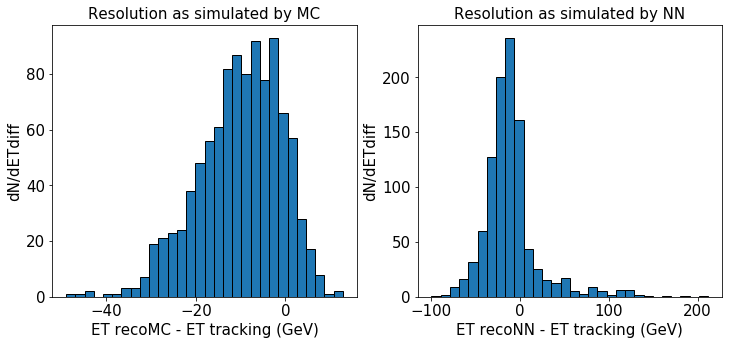

In [76]:

plt.subplot(1,2,1)
plt.tick_params(labelsize=15);
h_reco = plt.hist(diffMC/1000,bins=30,edgecolor='black');
plt.xlabel('ET recoMC - ET tracking (GeV)', fontsize=15)
plt.ylabel('dN/dETdiff', fontsize=15)
plt.title('Resolution as simulated by MC', fontsize=15)
plt.subplot(1,2,2)
plt.tick_params(labelsize=15);
h_nn = plt.hist(diffNN/1000,bins=30, edgecolor='black');
plt.xlabel('ET recoNN - ET tracking (GeV)', fontsize=15)
plt.ylabel('dN/dETdiff', fontsize=15)
plt.title('Resolution as simulated by NN', fontsize=15)
fig = plt.gcf()
fig.set_size_inches(12,5)
plt.savefig(PATH+'/resolution.eps', format='eps', dpi=100)




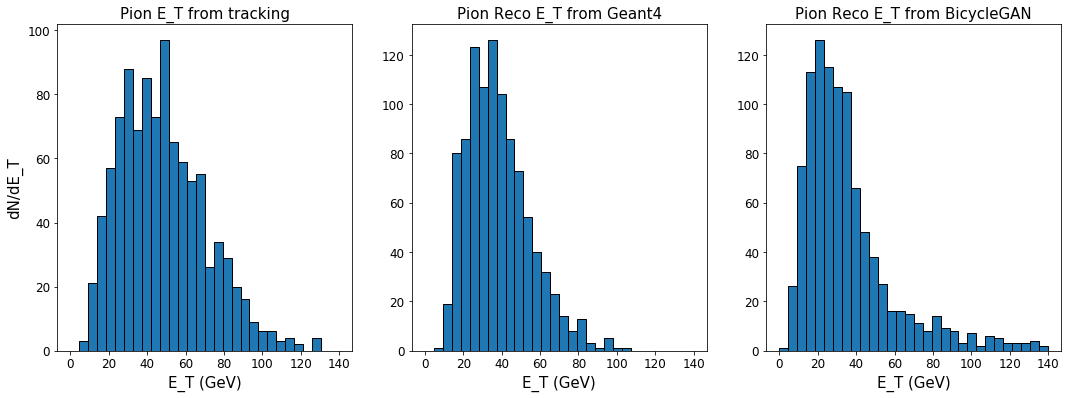

In [77]:
plt.subplot(1,3,1)
plt.tick_params(labelsize=12);
h_reco = plt.hist(test_true_hist/1000, range=(0,140),bins=30, edgecolor='black');
plt.xlabel('E_T (GeV)', fontsize=15)
plt.ylabel('dN/dE_T', fontsize=15)
plt.title('Pion E_T from tracking', fontsize=15)
plt.subplot(1,3,2)
plt.tick_params(labelsize=12);
h_reco = plt.hist(test_reco_MC_hist/1000, range=(0,140), bins=30,  edgecolor='black');
plt.xlabel('E_T (GeV)', fontsize=15)

plt.title('Pion Reco E_T from Geant4', fontsize=15)
plt.subplot(1,3,3)
plt.tick_params(labelsize=12);
h_nn = plt.hist(test_reco_NN_hist/1000, range=(0,140), bins=30,  edgecolor='black');
plt.xlabel('E_T (GeV)', fontsize=15)

plt.title('Pion Reco E_T from BicycleGAN', fontsize=15)
fig = plt.gcf()
fig.set_size_inches(18,6)
plt.savefig(PATH+'/distribution.eps', format='eps', dpi=100)

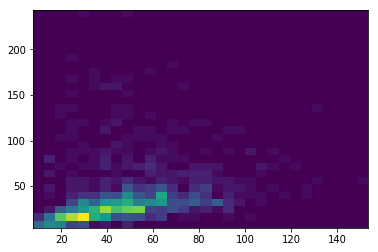

In [78]:
plt.hist2d(test_true_hist/1000,test_reco_NN_hist/1000,bins=30);

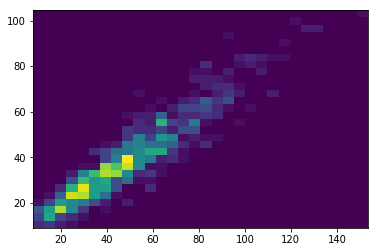

In [79]:
plt.hist2d(test_true_hist/1000,test_reco_MC_hist/1000,bins=30);

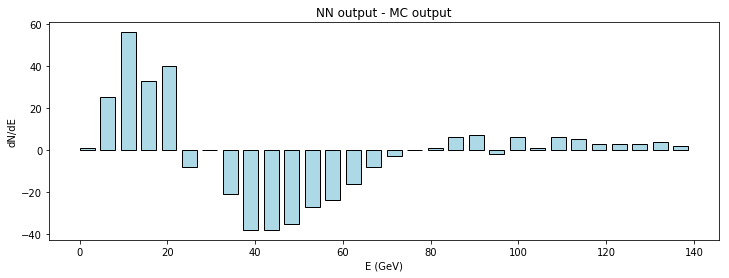

In [80]:
idx = np.arange(0,140, step=140/30)
diff=plt.bar(idx, 
             height=(h_nn[0]-h_reco[0]), edgecolor='black', 
             linewidth=1, color='lightblue',width = 3.4, align = 'edge') 
plt.xlabel('E (GeV)')
plt.ylabel('dN/dE')
plt.title("NN output - MC output")
fig = plt.gcf()
fig.set_size_inches(12,4)
plt.savefig(PATH+'/difference.eps', format='eps',dpi=100)

In [81]:
test_reco_NN.mean()

17.12299

In [82]:
test_reco.mean()

11.471488

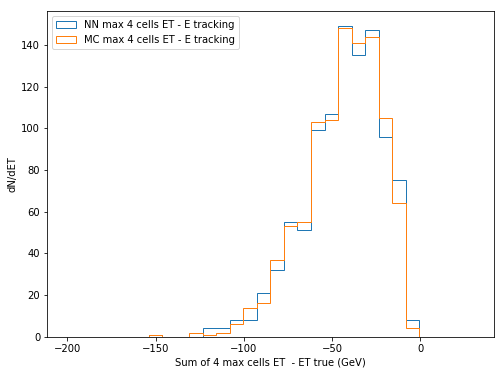

In [83]:
four_cells_diff_NN= np.array([
       four_cells(test_reco_NN_test[i]).sum()- test_true[i].sum()  for i in range(len(test_reco))
])    
four_cells_diff_MC= np.array([
       four_cells(test_reco[i]).sum() - test_true[i].sum() for i in range(len(test_reco))
])
plt.hist(four_cells_diff_NN/1000, bins=30, range=(-200,30), label = 'NN max 4 cells ET - E tracking',histtype='step')
plt.hist(four_cells_diff_MC/1000, bins=30, range=(-200,30), label = 'MC max 4 cells ET - E tracking', histtype='step')
plt.legend(loc=2);
plt.xlabel('Sum of 4 max cells ET  - ET true (GeV)')
plt.ylabel('dN/dET')
fig = plt.gcf()
fig.set_size_inches(8,6)
plt.savefig(PATH+'/four_cells_diff_combined.eps', format='eps', dpi=100)

four cells diff mean 270.8730773925781, std 2287.71044921875


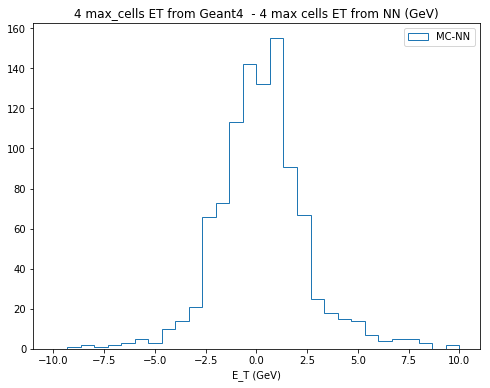

In [84]:
four_cells_diff= four_cells_diff_NN-four_cells_diff_MC
plt.title('4 max_cells ET from Geant4  - 4 max cells ET from NN (GeV)')
plt.hist((four_cells_diff)/1000, bins=30, range=(-10,10), label = 'MC-NN',  histtype='step');
plt.xlabel('E_T (GeV)')
plt.legend();
print('four cells diff mean {0}, std {1}'.format(four_cells_diff.mean(), four_cells_diff.std()))
fig = plt.gcf()
fig.set_size_inches(8,6)
plt.savefig(PATH+'/four_cells_diff.eps', format='eps', dpi=100)

In [85]:
hyper_dict={'LEARNING_RATE':LEARNING_RATE,
            'BETA1':BETA1,
            'BATCH_SIZE':BATCH_SIZE,
            'EPOCHS':EPOCHS,
            'SAVE_SAMPLE_PERIOD':SAVE_SAMPLE_PERIOD,
            'SEED':SEED,
            'd_sizes':d_sizes,
            'g_sizes_dec':g_sizes_dec,
            'g_sizes_enc':g_sizes_enc,
            'e_sizes':e_sizes,
            'cost_type':cost_type,
            'validating_size':validating_size,
            'test_size':test_size,
            'n_batches':n_batches,
            'reco_path':reco_path,
            'true_path':true_path,
            'discr_steps':discr_steps,
            'gen_steps':gen_steps,
            'vae_steps':vae_steps,
            'latent_weight':latent_weight,
            'cycl_weight':cycl_weight,
            'kl_weight':kl_weight,
           }

In [86]:
with open(PATH+'/hyper_parameters.pkl', 'wb') as f:  
    pickle.dump(hyper_dict, f)

In [87]:
b=(test_reco_NN_test-test_reco)/1000

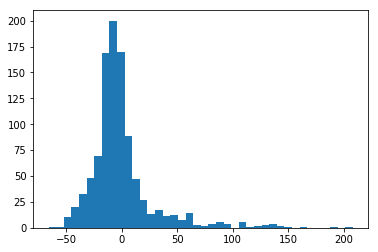

In [88]:
plt.hist(b.sum(axis=(1,2,3)),bins=40);

In [30]:
b.sum(axis=(1,2,3)).mean()

-5.5727487

In [31]:
b.sum(axis=(1,2,3)).std()

17.039783

In [32]:
test_reco_NN_test.shape

(1000, 52, 64, 1)

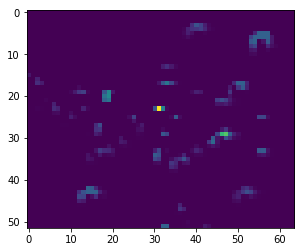

In [36]:
plt.imshow(test_reco_NN_test[1].reshape(52,64))